# Deep Learning (Autoencoder)

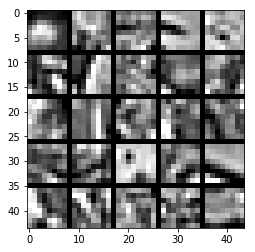

In [5]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b as minimize
from utils import normalize, tile_raster_images, sigmoid
from utils import ravelParameters, unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient

npy = 'data/images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X,img_shape=(8,8),tile_shape=(5,5),
                              tile_spacing=(1,1)),cmap='gray')
plt.show()

## (a) Implement cost function

We implement the function which computes the cost and the gradient of the sparse autoencoder.  This function will be passed to an optimization engine, together with the `theta` vector that contains the current state of all the model parameters. The first step of the function is therefore to unpack the `theta` vector into $W_1,W_2,b_1,b_2$. Some of the other steps are provided in the template below.

In [16]:
nV = 8*8       # number of visible units
nH = 25        # number of hidden units
dW = 0.0001    # weight decay term
sW = 3         # sparsity penalty term

def sparseAutoencoderCost(theta,nV,nH,dW,sW,X):
    W1,W2,b1,b2 = unravelParameters(theta,nH,nV)
    n = X.shape[0]
    z2 = np.dot(X, W1) + np.dot(np.ones((n,1)),b1.T) # z = Wx+b
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W2) + np.dot(np.ones((n,1)),b2.T)
    a3 = sigmoid(z3)
    eps = a3-X
    loss = .5/n * np.sum(eps**2)
    decay = .5 * (np.sum(W1**2) + np.sum(W2**2)) # weight decay regularization
    # Compute sparsity terms and total cost
    rho = 0.01
    a2mean = np.mean(a2,axis=0).reshape(nH,1)
    kl = np.sum(rho*np.log(rho/a2mean)+\
    (1-rho)*np.log((1-rho)/(1-a2mean)))
    dkl = -rho/a2mean+(1-rho)/(1-a2mean)
    cost = loss+dW*decay+sW*kl
    d3 = eps*a3*(1-a3)
    d2 = (sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
    W1grad = np.dot(X.T,d2)/n+dW*W1
    W2grad = np.dot(a2.T,d3)/n+dW*W2
    b1grad = np.dot(d2.T,np.ones((n,1)))/n
    b2grad = np.dot(d3.T,np.ones((n,1)))/n
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    print(' .',end="")
    return cost,grad
                                 
theta = initializeParameters(nH,nV)
cost,grad = sparseAutoencoderCost(theta,nV,nH,dW,sW,X)

 .

## (b) Gradient comparison

In [21]:
print('\nComparing numerical gradient with backprop gradient')

num_coords = 5
indices = np.random.choice(theta.size,num_coords,replace=False)
numgrad = computeNumericalGradient(lambda t:sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad = numgrad[indices]
subgrad = grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n',np.array([subnumgrad,subgrad]).T)
print('The relative difference is',diff)
print(diff<10**(-9))


Comparing numerical gradient with backprop gradient
 . . . . . . . . . .
 [[ 0.90519965  0.90519965]
 [ 0.90615503  0.90615504]
 [-0.00455793 -0.00455793]
 [ 0.90378219  0.90378219]
 [ 0.64626787  0.64626787]]
The relative difference is 1.0992141460222476e-10
True


## (c) Training


Training neural network
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

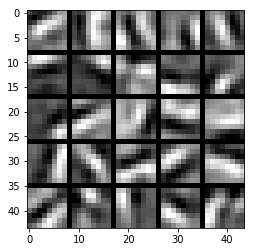

In [23]:
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,messages = minimize(sparseAutoencoderCost,
theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()